In [1]:
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
import scipy.stats
import os
import scipy.io as sio
import dnatools
%matplotlib inline
from pylab import *

# Plotting Params:
rc('mathtext', default='regular')
fsize=14


/net/gs/vol3/software/modules-sw-python/2.7.3/pandas/0.14.0/Linux/RHEL6/x86_64/lib/python2.7/site-packages/pandas/io/excel.py:626: UserWarning: Installed openpyxl is not supported at this time. Use >=1.6.1 and <2.0.0.
  .format(openpyxl_compat.start_ver, openpyxl_compat.stop_ver))


### Make directory to save results:

In [2]:
resultsdir = '../results/N10_A5SS_SNP_Prediction/'
if not os.path.exists(resultsdir):
    os.makedirs(resultsdir)
figdir = '../figures/N10_A5SS_SNP_Prediction/'
if not os.path.exists(figdir):
    os.makedirs(figdir)
    
#Choose if you want to actually save the plots:
SAVEFIGS = True

### Load Maxent SD scores:

In [3]:
f = open('../ref/MAXENT_ALL_SD.txt')
burge_sd_scores = {}
while True:
    line =  f.readline()[:-1]
    line =  f.readline()[:-1]
    if len(line)==0:
        break
    burge_sd_scores[line.split('\t')[0]] = float(line.split('\t')[1][8:])
f.close()


### Load Splice Site Model:

In [4]:
# Load Splice Site Model
data = sio.loadmat('../results/N7_A5SS_Model_Predictions/model_full_data.mat')
sd_scores = pd.DataFrame(index=dnatools.make_mer_list(6),data=data['Mer_scores'][:4**6*8].reshape(4**6,8)[:,2:6])
#exonic_mer6_scores = pd.read_pickle('../results/2015-03-11/exonic_mer6_scores.series')
#exonic_A3 = pd.read_pickle('../results/2015-03-11/exonic_acceptor_scores.series')
exonic_mer6_scores = pd.read_pickle('../results/N9_Training_Joint_A5SS_A3SS_Model/exonic_mer6_scores.series')
logit = lambda x: log(x)-log(1-x)
expit = lambda x: 1./(1.+exp(-x))

def score_seq(seq,mer_scores):
    score = 0.
    for b in range(4):
        score -= sd_scores.ix[seq[b:b+6],b]
    for b in range(0,len(seq)-5-6-3):
        score += mer_scores[seq[b:b+6]]
    # Score the SD:
    for b in range(4):
        score += sd_scores.ix[seq[len(seq)-9+b:len(seq)-9+6+b],b]
    return score

def score_maxent(seq):
    return burge_sd_scores[seq[-9:]]-burge_sd_scores[seq[:9]]

In [5]:
SNP_df = pd.read_pickle('../results/N10_A5SS_SNP_Prediction/All_SNPs.df')

#Get_gene_names:
header = ['chrom','splice_type','type','start','end','misc_1','strand','misc_2','ID']
A5SS = pd.read_csv('../ref/hg19_v2/A5SS.hg19.gff3',sep='\t',skiprows=1,names=header)
A5SS_events = A5SS[A5SS.type=='gene']
A5SS_events['gene'] = A5SS_events.ID.apply(lambda ID:ID.split(';')[-2].split('gsymbol=')[1])
gene_names = pd.Series(dict(zip(A5SS_events.ID.apply(lambda s:s[5:].split(';')[0]),A5SS_events.gene)))
SNP_df['GENE'] = gene_names[SNP_df.EVENT].values

SNP_df = SNP_df[SNP_df.WT_SEQ.apply(len)==SNP_df.MUT_SEQ.apply(len)]
# Find the actual location of SNPs. The listed positions might be wrong:
SNP_df['SNP_POS'] = SNP_df.apply(lambda x:dnatools.find_seq_diff_pos(x['WT_SEQ'],x['MUT_SEQ']),axis=1)
# Filter the SNPs
SNP_df = SNP_df[(SNP_df.SD_DIST<250) & (abs(SNP_df.WT_SEQ.apply(len)-SNP_df.MUT_SEQ.apply(len))==0) &\
                (SNP_df.SNP_POS>197) & ((SNP_df.WT_SEQ.apply(len)-SNP_df.SNP_POS)>194)]
SNP_df['WT_PSI'] = SNP_df.WT_PSI.apply(mean)
SNP_df['HETERO_PSI'] = SNP_df.HETERO_PSI.apply(mean)
SNP_df['HOMO_PSI'] = SNP_df.HOMO_PSI.apply(mean)
SNP_df['SD1_MUT'] = ((SNP_df.SNP_POS<=206) & (SNP_df.SNP_POS>197) )
SNP_df['SD2_MUT'] = (((SNP_df.WT_SEQ.apply(len)-SNP_df.SNP_POS)<=203 ) & ((SNP_df.WT_SEQ.apply(len)-SNP_df.SNP_POS)>=194) )
SNP_df['SS_MUT'] = SNP_df.SD1_MUT | SNP_df.SD2_MUT
SNP_df['ALT_EXON_MUT'] = ((SNP_df.SNP_POS>206) & ((SNP_df.WT_SEQ.apply(len)-SNP_df.SNP_POS)>203 ))

SNP_df['MUT_EFFECT_SIZE'] = SNP_df.MUT_SEQ.str.slice(198,-194).apply(lambda s:score_seq(s,exonic_mer6_scores))-\
                            SNP_df.WT_SEQ.str.slice(198,-194).apply(lambda s:score_seq(s,exonic_mer6_scores))
SNP_df['MAXENT_EFFECT_SIZE'] = SNP_df.MUT_SEQ.str.slice(198,-194).apply(lambda s:score_maxent(s))-\
                            SNP_df.WT_SEQ.str.slice(198,-194).apply(lambda s:score_maxent(s))
    
SNP_df['HOMO_PRED'] = expit(logit(SNP_df.WT_PSI)+SNP_df.MUT_EFFECT_SIZE)
SNP_df['HETERO_PRED'] = (SNP_df.WT_PSI+SNP_df.HOMO_PRED)/2.
SNP_df['HETERO_DPSI'] = SNP_df.HETERO_PSI-SNP_df.WT_PSI
SNP_df['HOMO_DPSI'] = SNP_df.HOMO_PSI-SNP_df.WT_PSI
SNP_df['HETERO_DPSI_PRED'] = SNP_df.HETERO_PRED-SNP_df.WT_PSI
SNP_df['HOMO_DPSI_PRED'] = SNP_df.HOMO_PRED-SNP_df.WT_PSI
SNP_df['LARGE_HETERO_EFFECT'] = abs(SNP_df.WT_PSI.apply(mean)-SNP_df.HETERO_PSI.apply(mean))>0.05
SNP_df['LARGE_HOMO_EFFECT'] = abs(SNP_df.WT_PSI.apply(mean)-SNP_df.HOMO_PSI.apply(mean))>0.05

Save the dataframe to include in the paper

In [17]:
SNP_df_2_save = SNP_df.copy(deep=True)
SNP_df_2_save['WT_COUNTS'] = SNP_df_2_save.WT_COUNTS.apply(size)
SNP_df_2_save['HETERO_COUNTS'] = SNP_df_2_save.HETERO_COUNTS.apply(size)
SNP_df_2_save['HOMO_COUNTS'] = SNP_df_2_save.HOMO_COUNTS.apply(size)
SNP_df_2_save.to_csv(resultsdir+'A5SS_SNP_Predictions.csv')

### Make predictions for $\Delta$ PSI in heterozygous and homozygous samples:

In [7]:
def get_accuracy(predictions,data):
    accuracy = {'Correct':sum(sign(predictions)==sign(data)),
                'Incorrect':sum(sign(-predictions)==sign(data)),
                'Total':len(predictions),
                'Total_with_Change':sum(abs(data)>0),
                'R2':scipy.stats.pearsonr(predictions,data)[0]**2,
                'R2_P_value':scipy.stats.pearsonr(predictions,data)[1]}
    return accuracy

### Get Statistics for Library:

In [8]:
prediction_accuracy = {}
# Heterozygous SNPs in SDs:
SNP_SD_HETERO = SNP_df[(SNP_df.WT_COUNTS.apply(size)>=2)&(SNP_df.HETERO_COUNTS.apply(size)>=2)&SNP_df.SS_MUT]
prediction_accuracy['SD_SNP_HETERO'] = get_accuracy(SNP_SD_HETERO.HETERO_DPSI_PRED,SNP_SD_HETERO.HETERO_DPSI)
prediction_accuracy['SD_SNP_HETERO_MAXENT'] = get_accuracy(SNP_SD_HETERO.MAXENT_EFFECT_SIZE,SNP_SD_HETERO.HETERO_DPSI)

# Heterozygous SNPs with large change in SDs:
SNP_SD_HETERO_LARGE = SNP_df[(SNP_df.WT_COUNTS.apply(size)>=2)&(SNP_df.HETERO_COUNTS.apply(size)>=2)&\
                             SNP_df.SS_MUT & SNP_df.LARGE_HETERO_EFFECT]
prediction_accuracy['SD_SNP_HETERO_LARGE'] = get_accuracy(SNP_SD_HETERO_LARGE.HETERO_DPSI_PRED,SNP_SD_HETERO_LARGE.HETERO_DPSI)
prediction_accuracy['SD_SNP_HETERO_LARGE_MAXENT'] = get_accuracy(SNP_SD_HETERO_LARGE.MAXENT_EFFECT_SIZE,SNP_SD_HETERO_LARGE.HETERO_DPSI)

# Homoozygous SNPs in SDs:
SNP_SD_HOMO = SNP_df[(SNP_df.WT_COUNTS.apply(size)>=2)&(SNP_df.HOMO_COUNTS.apply(size)>=2)&SNP_df.SS_MUT]
prediction_accuracy['SD_SNP_HOMO'] = get_accuracy(SNP_SD_HOMO.HETERO_DPSI_PRED,SNP_SD_HOMO.HETERO_DPSI)
prediction_accuracy['SD_SNP_HOMO_MAXENT'] = get_accuracy(SNP_SD_HOMO.MAXENT_EFFECT_SIZE,SNP_SD_HOMO.HETERO_DPSI)

# Homoozygous SNPs with large change in SDs:
SNP_SD_HOMO_LARGE = SNP_df[(SNP_df.WT_COUNTS.apply(size)>=2)&(SNP_df.HOMO_COUNTS.apply(size)>=2)&\
                             SNP_df.SS_MUT & SNP_df.LARGE_HOMO_EFFECT]
prediction_accuracy['SD_SNP_HOMO_LARGE'] = get_accuracy(SNP_SD_HOMO_LARGE.HOMO_DPSI_PRED,SNP_SD_HOMO_LARGE.HOMO_DPSI)
prediction_accuracy['SD_SNP_HOMO_LARGE_MAXENT'] = get_accuracy(SNP_SD_HOMO_LARGE.MAXENT_EFFECT_SIZE,SNP_SD_HOMO_LARGE.HOMO_DPSI)

SNP_ALT_EXON_HETERO = SNP_df[(SNP_df.WT_COUNTS.apply(size)>=10)&(SNP_df.HETERO_COUNTS.apply(size)>=10)&SNP_df.ALT_EXON_MUT]
prediction_accuracy['ALT_EXON_SNP_HETERO'] = get_accuracy(SNP_ALT_EXON_HETERO.HETERO_DPSI_PRED,SNP_ALT_EXON_HETERO.HETERO_DPSI)
# Heterozygous SNPs with large change in SDs:
SNP_ALT_EXON_HETERO_LARGE = SNP_df[(SNP_df.WT_COUNTS.apply(size)>=10)&(SNP_df.HETERO_COUNTS.apply(size)>=10)&\
                             SNP_df.ALT_EXON_MUT & SNP_df.LARGE_HETERO_EFFECT]
prediction_accuracy['ALT_EXON_SNP_HETERO_LARGE'] = get_accuracy(SNP_ALT_EXON_HETERO_LARGE.HETERO_DPSI_PRED,SNP_ALT_EXON_HETERO_LARGE.HETERO_DPSI)
# Homoozygous SNPs in SDs:
SNP_ALT_EXON_HOMO = SNP_df[(SNP_df.WT_COUNTS.apply(size)>=10)&(SNP_df.HOMO_COUNTS.apply(size)>=10)&SNP_df.ALT_EXON_MUT]
prediction_accuracy['ALT_EXON_SNP_HOMO'] = get_accuracy(SNP_ALT_EXON_HOMO.HETERO_DPSI_PRED,SNP_ALT_EXON_HOMO.HETERO_DPSI)
# Homoozygous SNPs with large change in SDs:
SNP_ALT_EXON_HOMO_LARGE = SNP_df[(SNP_df.WT_COUNTS.apply(size)>=10)&(SNP_df.HOMO_COUNTS.apply(size)>=10)&\
                             SNP_df.ALT_EXON_MUT & SNP_df.LARGE_HOMO_EFFECT]
prediction_accuracy['ALT_EXON_SNP_HOMO_LARGE'] = get_accuracy(SNP_ALT_EXON_HOMO_LARGE.HOMO_DPSI_PRED,SNP_ALT_EXON_HOMO_LARGE.HOMO_DPSI)


In [9]:
prediction_accuracy = pd.DataFrame(prediction_accuracy)
prediction_accuracy.T

,Correct,Incorrect,R2,R2_P_value,Total,Total_with_Change
ALT_EXON_SNP_HETERO,214,130,0.247871,6.022440e-23,344,344
ALT_EXON_SNP_HETERO_LARGE,37,6,0.556771,9.294295e-09,43,43
ALT_EXON_SNP_HOMO,79,52,0.201782,7.378128e-08,131,131
ALT_EXON_SNP_HOMO_LARGE,17,3,0.441133,1.404072e-03,20,20
SD_SNP_HETERO,154,46,0.469381,6.412517e-29,199,198
SD_SNP_HETERO_LARGE,81,12,0.676984,4.714628e-24,93,93
SD_SNP_HETERO_LARGE_MAXENT,76,17,0.397996,1.219703e-11,93,93
SD_SNP_HETERO_MAXENT,150,48,0.204944,1.902917e-11,199,198
SD_SNP_HOMO,50,14,0.416589,8.517321e-09,64,64
SD_SNP_HOMO_LARGE,35,0,0.593250,6.288338e-08,35,35


### P-values for Alt exon snps"

In [10]:
print 'Heterozygous P-value:',scipy.stats.binom_test(prediction_accuracy.ALT_EXON_SNP_HETERO_LARGE.Correct,
                             prediction_accuracy.ALT_EXON_SNP_HETERO_LARGE.Total_with_Change,0.5)
print 'Homozygous P-value:',scipy.stats.binom_test(prediction_accuracy.ALT_EXON_SNP_HOMO_LARGE.Correct,
                             prediction_accuracy.ALT_EXON_SNP_HOMO_LARGE.Total_with_Change,0.5)
print 'Combined P-value:',scipy.stats.binom_test(prediction_accuracy.ALT_EXON_SNP_HETERO_LARGE.Correct+\
                             prediction_accuracy.ALT_EXON_SNP_HOMO_LARGE.Correct,
                             prediction_accuracy.ALT_EXON_SNP_HETERO_LARGE.Total_with_Change+\
                             prediction_accuracy.ALT_EXON_SNP_HOMO_LARGE.Total_with_Change,
                             0.5)

Heterozygous P-value: 1.63612412507e-06
Homozygous P-value: 0.00257682800293
Combined P-value: 6.10827945169e-09


In [11]:
print 'Our Model'
print 'Heterozygous P-value:',scipy.stats.binom_test(prediction_accuracy.SD_SNP_HETERO_LARGE.Correct,
                             prediction_accuracy.SD_SNP_HETERO_LARGE.Total_with_Change,0.5)
print 'Homozygous P-value:',scipy.stats.binom_test(prediction_accuracy.SD_SNP_HOMO_LARGE.Correct,
                             prediction_accuracy.SD_SNP_HOMO_LARGE.Total_with_Change,0.5)
print 'Combined P-value:',scipy.stats.binom_test(prediction_accuracy.SD_SNP_HETERO_LARGE.Correct+\
                             prediction_accuracy.SD_SNP_HOMO_LARGE.Correct,
                             prediction_accuracy.SD_SNP_HETERO_LARGE.Total_with_Change+\
                             prediction_accuracy.SD_SNP_HOMO_LARGE.Total_with_Change,
                             0.5)
print 'MAXENT'
print 'Heterozygous P-value:',scipy.stats.binom_test(prediction_accuracy.SD_SNP_HETERO_LARGE_MAXENT.Correct,
                             prediction_accuracy.SD_SNP_HETERO_LARGE_MAXENT.Total_with_Change,0.5)
print 'Homozygous P-value:',scipy.stats.binom_test(prediction_accuracy.SD_SNP_HOMO_LARGE_MAXENT.Correct,
                             prediction_accuracy.SD_SNP_HOMO_LARGE_MAXENT.Total_with_Change,0.5)
print 'Combined P-value:',scipy.stats.binom_test(prediction_accuracy.SD_SNP_HETERO_LARGE_MAXENT.Correct+\
                             prediction_accuracy.SD_SNP_HOMO_LARGE_MAXENT.Correct,
                             prediction_accuracy.SD_SNP_HETERO_LARGE_MAXENT.Total_with_Change+\
                             prediction_accuracy.SD_SNP_HOMO_LARGE_MAXENT.Total_with_Change,
                             0.5)

Our Model
Heterozygous P-value: 9.82875021147e-14
Homozygous P-value: 5.82076609135e-11
Combined P-value: 1.55205954839e-22
MAXENT
Heterozygous P-value: 4.44630693777e-10
Homozygous P-value: 3.67290340364e-08
Combined P-value: 1.55583431535e-16


In [12]:
prediction_accuracy.ALT_EXON_SNP_HETERO_LARGE

Correct              3.700000e+01
Incorrect            6.000000e+00
R2                   5.567714e-01
R2_P_value           9.294295e-09
Total                4.300000e+01
Total_with_Change    4.300000e+01
Name: ALT_EXON_SNP_HETERO_LARGE, dtype: float64

In [13]:
get_accuracy(SNP_SD_HETERO.HETERO_DPSI_PRED,SNP_SD_HETERO.HETERO_DPSI)

{'Correct': 154,
 'Incorrect': 46,
 'R2': 0.46938145196951164,
 'R2_P_value': 6.4125165931169131e-29,
 'Total': 199,
 'Total_with_Change': 198}

In [14]:
prediction_accuracy = {}
burge_accuracy = {}
SPANR_accuracy = {}

In [15]:
SNP_SD_HETERO = SNP_df[(SNP_df.WT_COUNTS.apply(size)>=2)&(SNP_df.HETERO_COUNTS.apply(size)>=2)&SNP_df.SS_MUT]
SNP_SD_HOMO = SNP_df[(SNP_df.WT_COUNTS.apply(size)>=2)&(SNP_df.HOMO_COUNTS.apply(size)>=2)&SNP_df.SS_MUT]

In [16]:
prediction_accuracy

{}

In [17]:
def plot_snps(ax,df,yticks=True):
    df = df.sort(['SS_MUT','WT_PSI'])
    df.WT_PSI.plot(ax,kind='bar',color=cur_cols)
    ax.set_xticks(arange(len(df))+1)
    ax.set_xticklabels(df.GENE.values,rotation=45,ha='right')
    for i in xrange(len(df)):
        ax.plot([i+0.4,i+0.4],[df.WT_PSI.values[i],df.HETERO_PSI.values[i]],color=c1)
        ax.plot([i+0.8,i+0.8],[df.WT_PSI.values[i],df.HETERO_PRED.values[i]],color=c2)
        if pd.notnull(df.HOMO_PSI.values[i]):
           ax.plot([i+0.4,i+0.4],[df.WT_PSI.values[i],df.HOMO_PSI.values[i]],color=c1)
           ax.plot([i+0.8,i+0.8],[df.WT_PSI.values[i],df.HOMO_PRED.values[i]],color=c2)
    ax.plot(arange(len(df))+0.4,df.HETERO_PSI,linewidth=0,marker='o',color=c1)
    ax.plot(arange(len(df))+0.8,df.HETERO_PRED,linewidth=0,marker='o',color=c2)
    ax.plot(arange(len(df))+0.4,df.HOMO_PSI,linewidth=0,marker='s',color=c1)
    ax.plot(arange(len(df))+0.8,df.HOMO_PRED,linewidth=0,marker='s',color=c2)
    ax.tick_params(labelsize=fsize)
    ax.set_ylim([0,1])
    ax.xaxis.grid()
    if not yticks:
        ax.set_yticklabels([])
    #ax.set_ylabel('Long Isoform Fraction',fontsize=fsize)

In [18]:
SNP_SD_HETERO[SNP_SD_HETERO.LARGE_HETERO_EFFECT].shape

(93, 27)

In [19]:
def plot_snps(ax,df,yticks=True):
    df = df.sort(['SS_MUT','WT_PSI'])
    df.loc[pd.isnull(df.HOMO_PSI)]['HOMO_PRED']=nan
    df.WT_PSI.plot(ax,kind='bar',color=cur_cols,width=0.7)
    ax.set_xticks(arange(len(df))+0.7)
    ax.set_xticklabels(df.GENE.apply(lambda s:s.split(',')[0]).values,rotation=60,ha='right')
    offset=-0.6
    for i in xrange(len(df)):
        ax.plot([i+0.4+offset,i+0.4+offset],[df.WT_PSI.values[i],df.HETERO_PSI.values[i]],color=c1)
        ax.plot([i+0.8+offset,i+0.8+offset],[df.WT_PSI.values[i],df.HETERO_PRED.values[i]],color=c2)
        if not np.isnan(df.HOMO_PSI.values[i]):
            ax.plot([i+0.4+offset,i+0.4+offset],[df.WT_PSI.values[i],df.HOMO_PSI.values[i]],color=c1)
            ax.plot([i+0.8+offset,i+0.8+offset],[df.WT_PSI.values[i],df.HOMO_PRED.values[i]],color=c2)
    ax.plot(arange(len(df))+0.4+offset,df.HETERO_PSI,linewidth=0,marker='o',color=c1)
    ax.plot(arange(len(df))+0.8+offset,df.HETERO_PRED,linewidth=0,marker='o',color=c2)
    ax.plot(arange(len(df))+0.4+offset,df.HOMO_PSI,linewidth=0,marker='s',color=c1)
    ax.plot(arange(len(df))[np.isfinite(df.HOMO_PSI.values)]+0.8+offset,
            df.HOMO_PRED[np.isfinite(df.HOMO_PSI.values)],linewidth=0,marker='s',color=c2)
    ax.tick_params(labelsize=fsize)
    ax.set_ylim([0,1])
    ax.xaxis.grid()
    if not yticks:
        ax.set_yticklabels([])
    ax.set_xlim(-0.75,len(df)-0.25)
    #ax.set_ylabel('Long Isoform Fraction',fontsize=fsize)

### Plot SNPs in first SD:

/net/shendure/vol1/home/abros/VirtualEnvs/analysisenv/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead
  app.launch_new_instance()


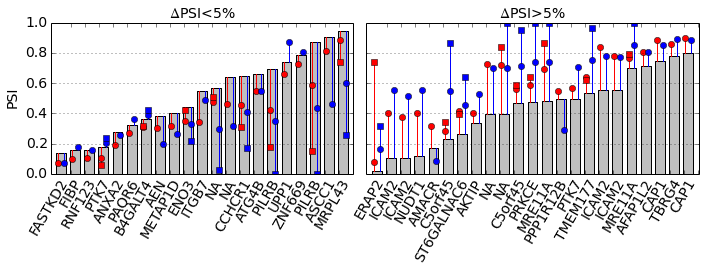

In [20]:
c1 = 'r'
c2 = 'b'
fsize = 14
fig = figure(figsize=(9,7))

SNP_df.sort('WT_PSI')
SNP_SD = SNP_SD_HETERO[(SNP_SD_HETERO.SD1_MUT)&(SNP_SD_HETERO.LARGE_HETERO_EFFECT)]
cur_df = SNP_SD[SNP_SD.HETERO_DPSI<0]
n1 = float(len(cur_df))
n = float(len(SNP_SD))

cur_cols = [[0.75,0.75,0.75] for i in range(len(cur_df))]
ax = fig.add_axes([0,0.5,n1/n-0.01,0.3])
plot_snps(ax,cur_df)
title('$\Delta$PSI<5%',fontsize=fsize)
ax.set_ylabel('PSI',fontsize=fsize)


cur_df = SNP_SD[SNP_SD.HETERO_DPSI>0]
cur_cols = [[0.75,0.75,0.75] for i in range(len(cur_df))]
ax = fig.add_axes([n1/n+0.01,0.5,1-n1/n-0.01,0.3])
plot_snps(ax,cur_df,False)
title('$\Delta$PSI>5%',fontsize=fsize)

handles, labels = ax.get_legend_handles_labels()
display = (0,1,2)

#Create custom artists
simArtist = plt.Line2D((0,1),(0,0), color=c1, marker='o', linestyle='')
heteroArtist = plt.Line2D((0,1),(0,0), color=c1, marker='s', linestyle='')
anyArtist = plt.Line2D((0,1),(0,0), color=c2, marker='o', linestyle='')
homoArtist = plt.Line2D((0,1),(0,0), color=c2, marker='s', linestyle='')
SD_snp = plt.Line2D((0,0),(1,0), color='g', marker='', linestyle='-',linewidth=4)

if SAVEFIGS:
    figname = 'Bar_predictions_SD1'
    fig.savefig(figdir+figname+'.pdf',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+figname+'.eps',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+figname+'.png',dpi=300,bbox_inches='tight')

### Plot SNPs in second SD:

/net/shendure/vol1/home/abros/VirtualEnvs/analysisenv/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead
  app.launch_new_instance()


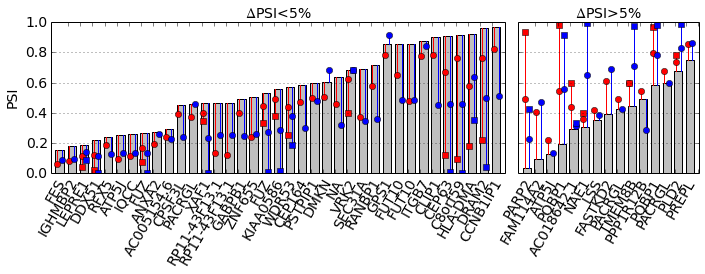

In [21]:
c1 = 'r'
c2 = 'b'
fsize = 14
fig = figure(figsize=(9,7))

SNP_df.sort('WT_PSI')
SNP_SD = SNP_SD_HETERO[(SNP_SD_HETERO.SD2_MUT)&(SNP_SD_HETERO.LARGE_HETERO_EFFECT)]
cur_df = SNP_SD[SNP_SD.HETERO_DPSI<0]
n1 = float(len(cur_df))
n = float(len(SNP_SD))

cur_cols = [[0.75,0.75,0.75] for i in range(len(cur_df))]
ax = fig.add_axes([0,0.0,n1/n-0.01,0.3])
plot_snps(ax,cur_df)
title('$\Delta$PSI<5%',fontsize=fsize)
ax.set_ylabel('PSI',fontsize=fsize)


cur_df = SNP_SD[SNP_SD.HETERO_DPSI>0]
cur_cols = [[0.75,0.75,0.75] for i in range(len(cur_df))]
ax = fig.add_axes([n1/n+0.01,0.0,1-n1/n-0.01,0.3])
plot_snps(ax,cur_df,False)
title('$\Delta$PSI>5%',fontsize=fsize)

if SAVEFIGS:
    figname = 'Bar_predictions_SD2'
    fig.savefig(figdir+figname+'.pdf',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+figname+'.eps',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+figname+'.png',dpi=300,bbox_inches='tight')

### Plot SNPs between SDs

/net/shendure/vol1/home/abros/VirtualEnvs/analysisenv/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead
  app.launch_new_instance()


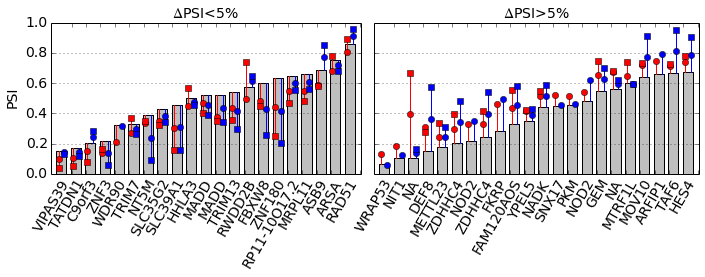

In [22]:
c1 = 'r'
c2 = 'b'
fsize = 14
fig = figure(figsize=(9,7))

SNP_AE = SNP_df[(SNP_df.WT_COUNTS.apply(size)>=10)&(SNP_df.HETERO_COUNTS.apply(size)>=10)&SNP_df.ALT_EXON_MUT]
SNP_AE = SNP_AE[(SNP_AE.LARGE_HETERO_EFFECT)]
cur_df = SNP_AE[SNP_AE.HETERO_DPSI<0]
n1 = float(len(cur_df))
n = float(len(SNP_AE))

cur_cols = [[0.75,0.75,0.75] for i in range(len(cur_df))]
ax = fig.add_axes([0,0.5,n1/n-0.01,0.3])
plot_snps(ax,cur_df)
title('$\Delta$PSI<5%',fontsize=fsize)
ax.set_ylabel('PSI',fontsize=fsize)


cur_df = SNP_AE[SNP_AE.HETERO_DPSI>0]
cur_cols = [[0.75,0.75,0.75] for i in range(len(cur_df))]
ax = fig.add_axes([n1/n+0.01,0.5,1-n1/n-0.01,0.3])
plot_snps(ax,cur_df,False)
title('$\Delta$PSI>5%',fontsize=fsize)

if SAVEFIGS:
    figname = 'Bar_predictions_Exon'
    fig.savefig(figdir+figname+'.pdf',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+figname+'.eps',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+figname+'.png',dpi=300,bbox_inches='tight')

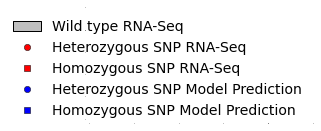

In [23]:
fig = figure(figsize=(4,2))
ax = fig.add_subplot(111)
leg = ax.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,heteroArtist,anyArtist,homoArtist],
          ['Wild type RNA-Seq', 'Heterozygous SNP RNA-Seq', 'Homozygous SNP RNA-Seq','Heterozygous SNP Model Prediction','Homozygous SNP Model Prediction'],\
          numpoints=1,bbox_to_anchor=(1,1),fontsize=fsize)
leg.get_frame().set_alpha(0)
ax.tick_params(size=0,labelsize=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

if SAVEFIGS:
    figname = 'Bar_legend'
    fig.savefig(figdir+figname+'.pdf',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+figname+'.eps',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+figname+'.png',dpi=300,bbox_inches='tight')

In [24]:
SNP_AE = SNP_df[(SNP_df.WT_COUNTS.apply(size)>=10)&(SNP_df.HETERO_COUNTS.apply(size)>=10)&SNP_df.ALT_EXON_MUT]

### Plot SNPs in SD Predictions Against Maxent

In [25]:
scaling_factor=0.8

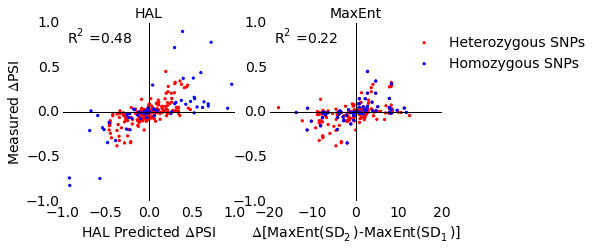

In [26]:
inds_hetero = find((SNP_df.HETERO_COUNTS.apply(size)>=2) & (SNP_df.WT_COUNTS.apply(size)>=2) & (SNP_df.SD1_MUT|SNP_df.SD2_MUT))
fig = figure(figsize=(8.5*scaling_factor,4*scaling_factor))
ax = fig.add_subplot(121)
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.scatter(SNP_df.iloc[inds_hetero].HETERO_DPSI_PRED,
           SNP_df.iloc[inds_hetero].HETERO_DPSI,
           color='r',s=5,label='Heterozygous SNPs')
inds_homo = find((SNP_df.HOMO_COUNTS.apply(size)>=2) & (SNP_df.WT_COUNTS.apply(size)>=2) & (SNP_df.SD1_MUT|SNP_df.SD2_MUT))
ax.scatter(SNP_df.iloc[inds_homo].HOMO_DPSI_PRED,
           SNP_df.iloc[inds_homo].HOMO_DPSI,
           color='b',s=5,label='Homozygous SNPs') 
r2= scipy.stats.pearsonr(np.concatenate((SNP_df.iloc[inds_hetero].HETERO_DPSI,
                                         SNP_df.iloc[inds_homo].HOMO_DPSI)),
                         np.concatenate((SNP_df.iloc[inds_hetero].HETERO_DPSI_PRED,
                                         SNP_df.iloc[inds_homo].HOMO_DPSI_PRED)))[0]**2
ax.set_ylabel('Measured $\Delta$PSI',fontsize=fsize)
ax.set_xlabel('HAL Predicted $\Delta$PSI',fontsize=fsize)
ax.tick_params(labelsize=fsize)
ax.axis([-1,1,-1,1])
ax.text(-0.95,0.96,'$R^2$=%0.2f' %r2,fontsize=fsize,ha='left',va='top')
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.tick_params(size=0)
ax.set_title("HAL", fontsize=fsize)

ax = fig.add_subplot(122)
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.scatter(SNP_df.iloc[inds_hetero].MAXENT_EFFECT_SIZE,
           SNP_df.iloc[inds_hetero].HETERO_DPSI,
           color='r',s=5,label='Heterozygous SNPs')
ax.scatter(SNP_df.iloc[inds_homo].MAXENT_EFFECT_SIZE,
           SNP_df.iloc[inds_homo].HETERO_DPSI,
           color='b',s=5,label='Homozygous SNPs')
r2= scipy.stats.pearsonr(np.concatenate((SNP_df.iloc[inds_hetero].HETERO_DPSI,
                                         SNP_df.iloc[inds_homo].HOMO_DPSI)),
                         np.concatenate((SNP_df.iloc[inds_hetero].MAXENT_EFFECT_SIZE/2,
                                         SNP_df.iloc[inds_homo].MAXENT_EFFECT_SIZE)))[0]**2
#ax.set_ylabel('Measured $\Delta$PSI',fontsize=fsize)
ax.set_xlabel('$\Delta$[MaxEnt($SD_2)-MaxEnt(SD_1$)]',fontsize=fsize)
ax.tick_params(labelsize=fsize)
ax.axis([-20,20,-1,1])
ax.set_xticks(arange(-20,21,10))
ax.text(-0.95*20,0.96*1,'$R^2$=%0.2f' %r2,fontsize=fsize,ha='left',va='top')
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.tick_params(size=0)
ax.set_title("MaxEnt", fontsize=fsize)

leg = ax.legend(bbox_to_anchor=(1.9,1),scatterpoints=1,fontsize=fsize)
leg.get_frame().set_alpha(0)

if SAVEFIGS:
    figname = 'SNPs_SD_comparison'
    fig.savefig(figdir+figname+'.pdf',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+figname+'.eps',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+figname+'.png',dpi=300,bbox_inches='tight')

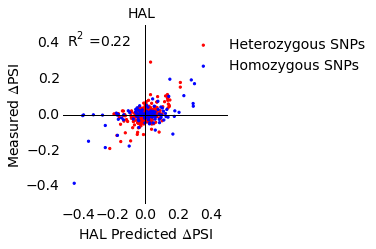

In [27]:
inds_hetero = find((SNP_df.HETERO_COUNTS.apply(size)>=10) & (SNP_df.WT_COUNTS.apply(size)>=10) & (SNP_df.ALT_EXON_MUT))
fig = figure(figsize=(3.7*scaling_factor,4*scaling_factor))
ax = fig.add_subplot(111)
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.scatter(SNP_df.iloc[inds_hetero].HETERO_DPSI_PRED,
           SNP_df.iloc[inds_hetero].HETERO_DPSI,
           color='r',s=5,label='Heterozygous SNPs')
inds_homo = find((SNP_df.HOMO_COUNTS.apply(size)>=10) & (SNP_df.WT_COUNTS.apply(size)>=10) & (SNP_df.ALT_EXON_MUT))
ax.scatter(SNP_df.iloc[inds_homo].HOMO_DPSI_PRED,
           SNP_df.iloc[inds_homo].HOMO_DPSI,
           color='b',s=5,label='Homozygous SNPs') 
r2= scipy.stats.pearsonr(np.concatenate((SNP_df.iloc[inds_hetero].HETERO_DPSI,
                                         SNP_df.iloc[inds_homo].HOMO_DPSI)),
                         np.concatenate((SNP_df.iloc[inds_hetero].HETERO_DPSI_PRED,
                                         SNP_df.iloc[inds_homo].HOMO_DPSI_PRED)))[0]**2
ax.set_ylabel('Measured $\Delta$PSI',fontsize=fsize)
ax.set_xlabel('HAL Predicted $\Delta$PSI',fontsize=fsize)
ax.tick_params(labelsize=fsize)
ax.axis([-0.5,0.5,-0.5,0.5])
ax.text(-0.95*0.5,0.96*0.5,'$R^2$=%0.2f' %r2,fontsize=fsize,ha='left',va='top')
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.tick_params(size=0)

leg = ax.legend(bbox_to_anchor=(1.9,1),scatterpoints=1,fontsize=fsize)
leg.get_frame().set_alpha(0)
fig.suptitle("HAL", fontsize=fsize)
if SAVEFIGS:
    figname = 'SNPs_A5SS_Alt_exon_scatter'
    fig.savefig(figdir+figname+'.pdf',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+figname+'.eps',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+figname+'.png',dpi=300,bbox_inches='tight')